Please do one of the following.


# Part I: Classification

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [182]:
import pandas as pd
import seaborn
import numpy.random as nprnd
import random
import json
import numpy as np
import matplotlib.pyplot as plt
import pydotplus
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier  
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus

df = pd.read_csv("https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv",index_col = 0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [183]:
df['default'] = df['default'].replace("No",0).replace("Yes",1)
df['student'] = df['student'].replace("No",0).replace("Yes",1)
df.head()

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

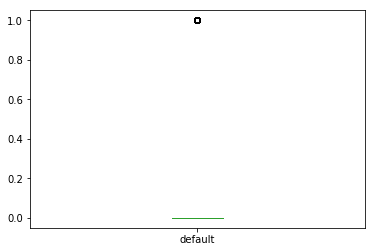

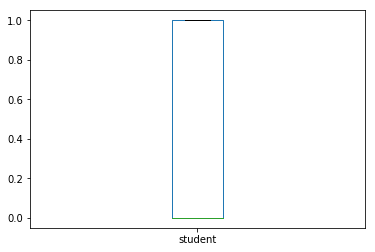

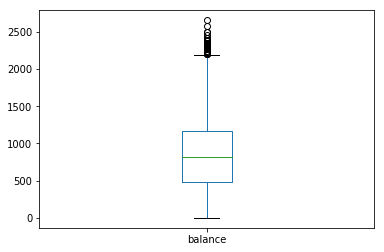

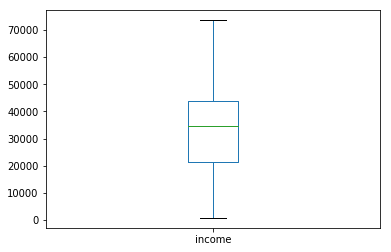

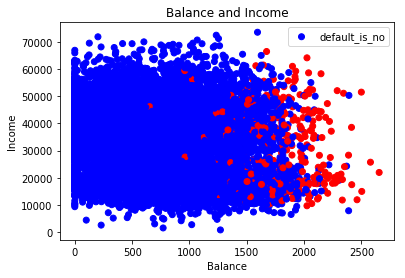

In [184]:
df['default'].plot.box()
plt.show()

df['student'].plot.box()
plt.show()

df['balance'].plot.box()
plt.show()

df['income'].plot.box()
plt.show()


colors= {0:"blue",1:"red"}
plt.scatter(df["balance"],df["income"],c = df["default"].apply(lambda x:colors[x]))
plt.title("Balance and Income")
plt.xlabel("Balance")
plt.ylabel("Income")
plt.legend(['default_is_no'])
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

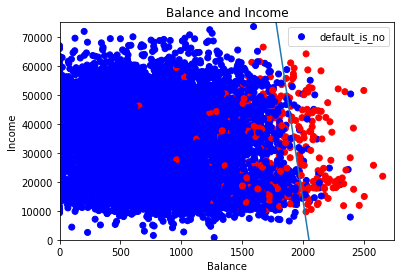

AUC ROC : 0.946144


In [185]:
X = df[["balance","income"]]
y = df["default"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regr = LogisticRegression(penalty = "l1")
model = regr.fit(X_train, y_train)

colors= {0:"blue",1:"red"}
plt.scatter(df["balance"],df["income"],c = df["default"].apply(lambda x:colors[x]))
plt.title("Balance and Income")
plt.xlabel("Balance")
plt.ylabel("Income")
plt.legend(['default_is_no'])

bound = model.intercept_
coef = model.coef_[0]
x = np.arange(0,2500)
y = (bound+coef[0]*x)/-coef[1]

plt.plot(x,y)
plt.xlim(0,2750)
plt.ylim(0,75000)
plt.show()

def generate_auc(X,y,clf_class,**kwargs):
    random_state = np.random.RandomState(0)
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("AUC ROC : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds
    
fpr, tpr, roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

The proformance isn't changed much, but it does show that a student is more likely to default that a non-student.

AUC ROC : 0.954367


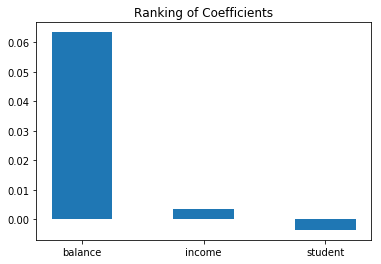

In [186]:
X = df[["balance","income","student"]]
y = df["default"]
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

def generate_auc(X,y,clf_class,**kwargs):
    random_state = np.random.RandomState(0)
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("AUC ROC : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds
    
fpr, tpr, roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')

alphas = np.logspace(-6, -1, 100)
score = []
for alpha in alphas:
    clf = Ridge(alpha=alpha)
    clf.fit(X_train, y_train)
    score.append(clf.score(X_test, y_test))
opt_index = np.array(score).argmax()

clf = Ridge(alpha=alphas[opt_index])
clf.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(3), clf.coef_, 0.5)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('balance', 'income', 'student'))
rects = ax.patches
plt.title("Ranking of Coefficients")
plt.show()

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

The model is robust.

In [187]:
score = cross_val_score(regr, X_train, y_train, cv=6)
print(score)

[ 0.97451274  0.97151424  0.9699925   0.97224306  0.97224306  0.97374344]


7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

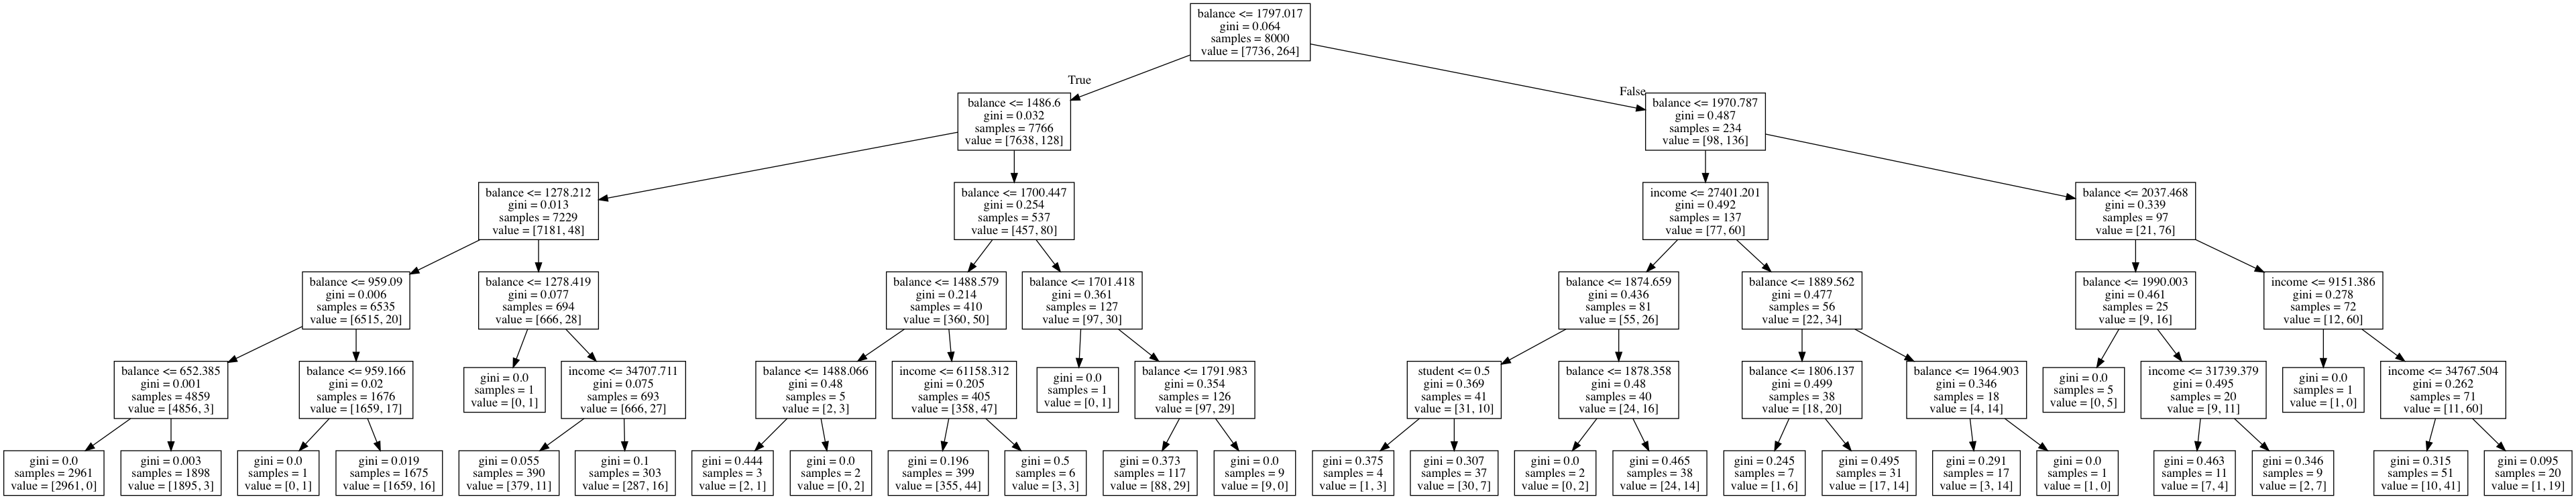

In [188]:
X = df[['student','balance','income']]
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

dot_data = StringIO()  
export_graphviz(clf, out_file=dot_data, feature_names=X_train.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

8) Find the optimal decision tree depth and compute the AUC ROC. 

Optimal Desicion Tree Depth: 3.


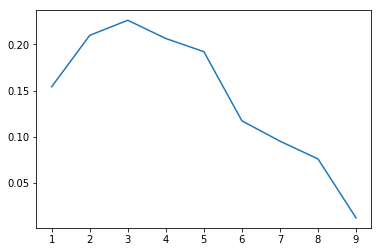

AUC ROC: 0.932152


In [189]:
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,10)
for n in depths:
    regrD = DecisionTreeRegressor(max_depth=n)
    regrD.fit(X_train, y_train)
    train_errors.append(regrD.score(X_train , y_train))
    scores.append(regrD.score(X_test , y_test))
plt.plot(depths,scores)
test_errors = scores
opt = depths[np.argmax(scores)]
print("Optimal Desicion Tree Depth: {0}.".format(opt))
plt.show()

reg_opt = DecisionTreeClassifier(criterion='entropy', max_depth= opt)
reg_opt.fit(X_train,y_train)
probas_ = reg_opt.predict_proba(X_test)    
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc_tree = auc(fpr,tpr)
print ("AUC ROC: %f" % roc_auc_tree)

# Part II: Recommendation Systems. 

In this problem we will use the notebook https://github.com/Columbia-Intro-Data-Science/APMAE4990-/blob/master/notebooks/matrix_factorization_recommender.ipynb  as
a starting point.

1) Split the ratings matrix `R_df` into training and testing sets. Remember we need to do this for rows and columns now. 

2) Evaluate the performance of the matrix factorization model for $K=50$. In particular, measure the:
 - Precision.
 - Recall. 

You can round up or down to the nearest integer for the ratings. 

3) Construct an item/item and user/user model, and evaluate the performance as in 2). How does it compare?

4) Check how your answer to 3) changes (if at all) as you try different values of K for K=10, 20, 100. 